In [5]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
#from sklearn.preprocessing import Normalizer
#from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA

from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

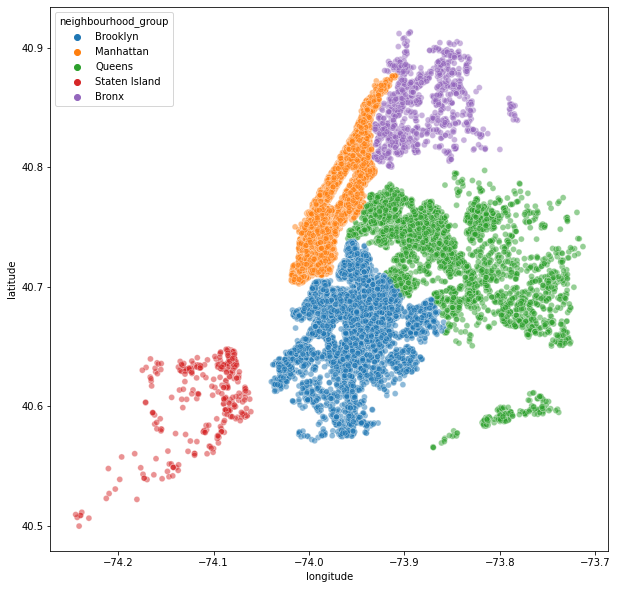

In [ ]:
df = pd.read_csv(r'/content/AB_NYC_2019.csv')
df['log_price'] = np.log(df['price'])
plt.figure(figsize=(10,10))
sns.scatterplot(data=df,x='longitude',y='latitude',hue='neighbourhood_group',alpha=0.5)

<AxesSubplot:xlabel='log_price', ylabel='Count'>

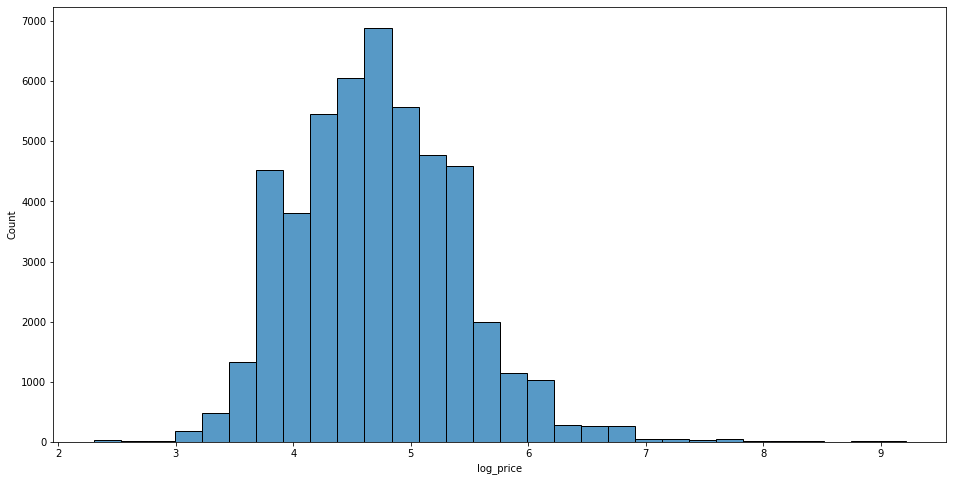

In [ ]:
plt.figure(figsize=(16,8))
sns.histplot(data=df,x='log_price',bins=30)

In [ ]:
df.count()

id                                48895
name                              48879
host_id                           48895
host_name                         48874
neighbourhood_group               48895
neighbourhood                     48895
latitude                          48895
longitude                         48895
room_type                         48895
price                             48895
minimum_nights                    48895
number_of_reviews                 48895
last_review                       38843
reviews_per_month                 38843
calculated_host_listings_count    48895
availability_365                  48895
log_price                         48895
dtype: int64

In [ ]:
df = pd.read_csv(r'/content/AB_NYC_2019.csv')

labelencoder = LabelEncoder()
order = df.groupby('neighbourhood').agg({'price':''})
df['neighborhood_label'] = labelencoder.fit_transform(df['neighbourhood'])
df[['neighbourhood','neighborhood_label']].drop_duplicates().sort_values('neighbourhood')

,neighbourhood,neighborhood_label
510,Allerton,0
29604,Arden Heights,1
702,Arrochar,2
1327,Arverne,3
257,Astoria,4
...,...,...
25,Windsor Terrace,216
3020,Woodhaven,217
433,Woodlawn,218
3049,Woodrow,219


In [6]:
df = pd.read_csv(r'/content/AB_NYC_2019.csv')
df = df.drop(columns=['id','host_name','latitude','longitude'])

df["new_listing"] = 0
df["new_listing"][df["last_review"].isnull()] = 1

df['last_review'].fillna(0,inplace=True)
df['last_review'] = pd.to_datetime(df['last_review'])
df['review_recency'] = (df.last_review.max() - df.last_review).dt.days

df['all_year_avail'] = (df['availability_365']>350).astype(int)
df['low_avail'] = (df['availability_365']< 12).astype(int)

df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
df['months'] = df['number_of_reviews']/df['reviews_per_month']
df['months'] = df['months'].fillna(0)

#labelencoder = LabelEncoder()
#df['neighborhood_label'] = labelencoder.fit_transform(df['neighbourhood'])

df['type'] = 1
df_pivoted = df.pivot(columns='room_type',values='type').fillna(0)
df = df.join(df_pivoted)
df_pivoted = df.pivot(columns='neighbourhood_group',values='type').fillna(0)
df = df.join(df_pivoted)
df_pivoted = df.pivot(columns='neighbourhood',values='type').fillna(0)
df = df.join(df_pivoted)
df = df.drop(columns=['type','room_type','neighbourhood_group','neighbourhood'])
"""
big_host = df.groupby('host_id').agg({'name':'count'}).reset_index().rename(columns={'name':'count'})
big_host = big_host[big_host['count']>=50]
host_list = big_host.host_id.tolist()
big_host['type'] = 1
big_host_pivoted = big_host.pivot(columns='host_id',values='type').fillna(0)
big_host = big_host.join(big_host_pivoted)
big_host = big_host.drop(columns=['count','type'])

df = pd.merge(df,big_host,on='host_id',how='left').drop(columns='host_id')
df[host_list] = df[host_list].fillna(0)
df.columns = df.columns.astype(str)
"""
df['price'] = np.log(df['price']+1)

df

<ipython-input-6-0f04511de7ec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["new_listing"][df["last_review"].isnull()] = 1


,name,host_id,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,new_listing,...,Westerleigh,Whitestone,Williamsbridge,Williamsburg,Willowbrook,Windsor Terrace,Woodhaven,Woodlawn,Woodrow,Woodside
0,Clean & quiet apt home by the park,2787,5.010635,1,9,2018-10-19,0.21,6,365,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Skylit Midtown Castle,2845,5.420535,1,45,2019-05-21,0.38,2,355,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,5.017280,3,0,1970-01-01,0.00,1,365,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cozy Entire Floor of Brownstone,4869,4.499810,1,270,2019-07-05,4.64,1,194,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Entire Apt: Spacious Studio/Loft by central park,7192,4.394449,10,9,2018-11-19,0.10,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,Charming one bedroom - newly renovated rowhouse,8232441,4.262680,2,0,1970-01-01,0.00,2,9,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48891,Affordable room in Bushwick/East Williamsburg,6570630,3.713572,4,0,1970-01-01,0.00,2,36,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48892,Sunny Studio at Historical Neighborhood,23492952,4.753590,10,0,1970-01-01,0.00,1,27,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48893,43rd St. Time Square-cozy single bed,30985759,4.025352,1,0,1970-01-01,0.00,6,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
#unused

df = df.drop(columns=['name','last_review'])

In [8]:
cols = df.columns.tolist()
cols.remove('price')
X = df[cols]
y = df[['price']]


In [ ]:
#one hot

R2: 0.5412735822565817
RMSE: 0.4711261626777644

In [ ]:
#label

R2: 0.528926382654413
RMSE: 0.476105051989829

In [52]:
parameters = [{
'n_estimators': [100,150,200],
'max_samples': [0.8,1.0],
'max_features' : [0.8,1.0],
'oob_score': [True,False]}]

model = GridSearchCV(BaggingRegressor(), parameters, scoring='r2')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model.fit(X_train, y_train)
print(model.best_params_)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5

print('R2:',r2)
print('RMSE:',rmse)

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

{'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 150}
R2: 0.5929461240766113
RMSE: 0.4396018198256612


In [12]:
model = BaggingRegressor(n_estimators = 150, max_features= 0.8, max_samples = 0.8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5

print('R2:',r2)
print('RMSE:',rmse)

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


R2: 0.5957742978256133
RMSE: 0.43838188449625465


R2: 0.5957742978256133
RMSE: 0.43838188449625465


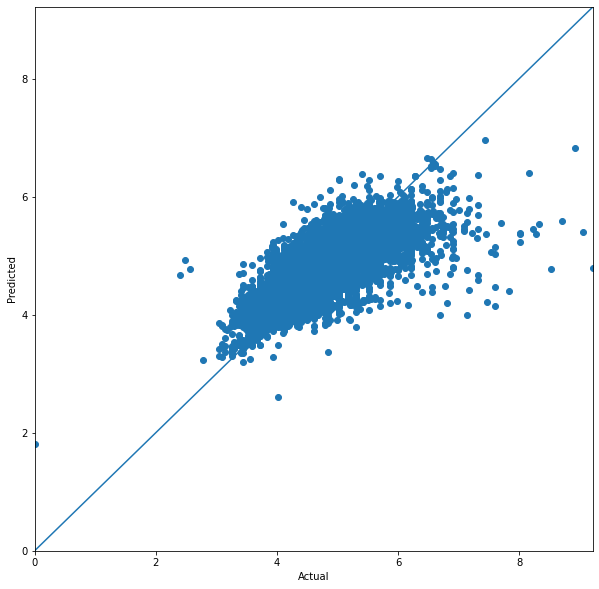

In [14]:
plt.figure(figsize=(10,10))
plt.scatter(y_test,y_pred)

max_val = max(np.max(y_test)[0],np.max(y_pred))
plt.xlim(0,max_val)
plt.ylim(0,max_val)
plt.plot([0,max_val],[0,max_val])
plt.ylabel('Predicted')
plt.xlabel('Actual')

print('R2:',r2_score(y_test, y_pred))
print('RMSE:',mean_squared_error(y_test, y_pred)**0.5)